# RNN based on time series: Predict Action and next steps

We aim to predict the next steps and actions based on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

### Get the data
First Import it using pandas

In [4]:

raw_dataset = pd.read_csv("./data/fromStateToAction_df (28) last.csv")

dataset = raw_dataset.copy()


We need all the path to have the same steps. Therefore we will trunk the path to the same lenght and omit those with reduced lenght

First we check with is the most common lenght

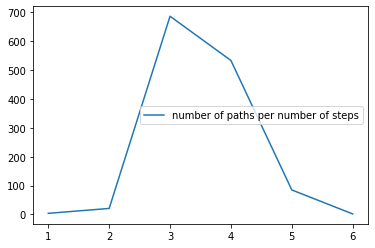

In [5]:
len_stat = dataset.groupby(["id_camino"]).size().reset_index(name='counts')
plt.plot(len_stat.groupby(["counts"]).size(), label ="number of paths per number of steps")
plt.legend()

In [32]:
training_size = len(dataset)

4673

We will cut at CUT_STEP steps (n=CUT_STEP+1) and remove the path with less than CUT_STEP

In [6]:
# N_STEPS= 3

# long_paths = len_stat[len_stat.counts>N_STEPS]
# red_dataset = dataset.loc[dataset["id_camino"].isin(long_paths["id_camino"])]
# reg_dataset= red_dataset[red_dataset.id_in_seq< (N_STEPS+1)] 

In [6]:
def class_to_action (class_int):
    with open('./data/class_to_action (28).json') as json_file:
        CtA = json.load(json_file)
        
    action = CtA[class_int]
    return action

In [7]:
N_CATEGORIES = 28

dataset["A0"] = np.nan
dataset["A1"] = np.nan

for index, row in dataset.iterrows():
    CS_array =np.array(eval(row["current_state"]))
    dataset["current_state"][index] = CS_array
    GS_array =np.array(eval(row["goal_state"]))
    dataset["goal_state"][index] = GS_array
    dataset["A0"][index] = class_to_action(str(dataset["out_action"][index]))[0]
    dataset["A1"][index] = class_to_action(str(dataset["out_action"][index]))[1]

# Usar estado final 
dataset["Difference"] =   dataset["goal_state"]-dataset["current_state"]

dataset[["C0",'C1',"C2","C3",'C4',"C5"]] = pd.DataFrame(dataset.current_state.values.tolist(), index= dataset.index)
dataset[["D0",'D1',"D2","D3",'D4',"D5"]] = pd.DataFrame(dataset.Difference.values.tolist(), index= dataset.index)


### Clean the data

We keep the columns we are interested in 

In [8]:
dataset_short= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]


In [9]:
dataset_short.head()

,id_camino,D0,D1,D2,D3,D4,D5,A0,A1
0,0,2241.022698,-316.657474,0.461107,0.145088,-0.020134,-0.000762,-0.06981,0.0
1,0,1745.057520,-267.032650,0.153301,-0.019156,-0.088964,-0.000818,-0.01745,0.0
2,0,874.820341,-65.086918,-1.045562,0.059299,0.160137,-0.001426,-0.05236,0.0
3,0,292.139470,-29.003206,0.084644,-0.002623,-0.083223,0.001795,-0.05236,0.0
4,1,1640.344763,-282.435881,1.053526,0.115329,-0.108648,0.003646,-0.10472,0.0


## Normalize the data

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [10]:
reduced_dataset = dataset_short.copy()
reduced_dataset.pop("A0")
reduced_dataset.pop("A1")
reduced_dataset.pop("id_camino")
data_stats = reduced_dataset.describe()
data_stats = data_stats.transpose()

In [11]:
def norm(x, train_stats):
  return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(reduced_dataset, data_stats)
normed_dataset = normed_data.join(dataset_short[["A0","A1","id_camino"]])


In [12]:
normed_dataset

,D0,D1,D2,D3,D4,D5,A0,A1,id_camino
0,1.597174,-1.701022,0.694298,1.149717,-0.151368,-0.270578,-0.06981,0.000000,0
1,0.844793,-1.353181,0.258761,-0.299719,-0.421934,-0.272760,-0.01745,0.000000,0
2,-0.475359,0.062338,-1.437601,0.392641,0.557264,-0.296318,-0.05236,0.000000,0
3,-1.359287,0.315264,0.161613,-0.153814,-0.399367,-0.171398,-0.05236,0.000000,0
4,0.685944,-1.461149,1.532556,0.887092,-0.499312,-0.099633,-0.10472,0.000000,1
...,...,...,...,...,...,...,...,...,...
4668,-1.310382,0.387553,-0.851743,-0.844282,-1.889993,1.242704,-0.05236,0.000000,1329
4669,1.410969,-0.341706,1.211883,0.919714,-0.189896,-0.221773,-0.08727,0.000000,1330
4670,0.729329,-0.046772,0.987713,-0.693059,-0.400756,-0.186452,-0.05236,0.000000,1330
4671,-0.120309,0.377121,0.459612,-0.343413,-0.105945,-0.252881,-0.05236,0.158556,1330


## Pad the data

In [15]:
N_STEPS= 3
PAD_LEN = N_STEPS+1

In [13]:
padded_data = []
for camino in normed_dataset["id_camino"]:
    group = normed_dataset[normed_dataset["id_camino"]==camino]
    group.pop("id_camino")
    padded_data.append(group.values)

In [16]:
dataset2 = tf.keras.preprocessing.sequence.pad_sequences(padded_data, maxlen=PAD_LEN, dtype='float64', padding='pre', truncating='pre', value=0.0)
dataset2[9]

array([[ 1.16414962, -0.99859692,  0.46871019,  1.20112044,  0.11262316,
        -0.41473824, -0.06981   ,  0.        ],
       [ 0.4117691 , -0.6507564 ,  0.03317248, -0.24831561, -0.15794313,
        -0.41692087, -0.03491   ,  0.        ],
       [-0.60139949, -0.040385  , -0.56412469,  0.1324287 ,  0.21002957,
        -0.37724571, -0.03491   ,  0.        ],
       [-1.62101257,  0.50575168, -0.64401972,  0.14390399,  0.28123166,
        -0.41044529, -0.05236   ,  0.        ]])

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [17]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [22]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2
target_dataset = dataset2[:,:,6:8]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [23]:
x_train_single_sequential[0]

array([[ 1.59717363, -1.70102178,  0.6942984 ,  1.1497174 , -0.15136753,
        -0.27057772, -0.06981   ,  0.        ],
       [ 0.84479311, -1.35318126,  0.25876069, -0.29971865, -0.42193381,
        -0.27276035, -0.01745   ,  0.        ],
       [-0.47535904,  0.06233832, -1.43760069,  0.39264118,  0.55726444,
        -0.29631792, -0.05236   ,  0.        ]])

In [24]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (3, 8)


In [25]:
y_train_single_sequential[0]

array([[-0.01745,  0.     ],
       [-0.05236,  0.     ],
       [-0.05236,  0.     ]])

In [26]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [34]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True,input_shape=(None, 8)))
single_step_sequential_model.add(tf.keras.layers.Dense(2, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mse','mae'])

### Inspect the model

In [35]:
single_step_sequential_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 11)          880       
_________________________________________________________________
dense_2 (Dense)              (None, None, 2)           24        
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [36]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 233.65 steps, validate for 50 steps
Epoch 1/20
234/233 [==============================] - 11s 46ms/step - loss: 0.0497 - mse: 0.0050 - mae: 0.0497 - val_loss: 0.0348 - val_mse: 0.0023 - val_mae: 0.0348
Epoch 2/20
234/233 [==============================] - 3s 12ms/step - loss: 0.0313 - mse: 0.0021 - mae: 0.0313 - val_loss: 0.0306 - val_mse: 0.0021 - val_mae: 0.0306
Epoch 3/20
234/233 [==============================] - 2s 9ms/step - loss: 0.0291 - mse: 0.0019 - mae: 0.0291 - val_loss: 0.0287 - val_mse: 0.0020 - val_mae: 0.0287
Epoch 4/20
234/233 [==============================] - 2s 8ms/step - loss: 0.0279 - mse: 0.0019 - mae: 0.0279 - val_loss: 0.0278 - val_mse: 0.0019 - val_mae: 0.0278
Epoch 5/20
234/233 [==============================] - 3s 11ms/step - loss: 0.0276 - mse: 0.0018 - mae: 0.0276 - val_loss: 0.0274 - val_mse: 0.0018 - val_mae: 0.0274
Epoch 6/20
234/233 [==============================] - 2s 10ms/step - loss: 0.0270 - mse: 0.0018 - mae: 0.0270 - val_loss: 0.0272 -

Compute the accuracy

In [37]:
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [39]:
def closest_category(X, pred):
    tree = sklearn.neighbors.KDTree(X, leaf_size=2)
    dist, ind = tree.query(pred, k=1)
    return ind

In [56]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

0.47593582


In [49]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

935/935 - 0s - loss: 0.0229 - mse: 0.0013 - mae: 0.0229


Visualize the model's training progress.

In [52]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

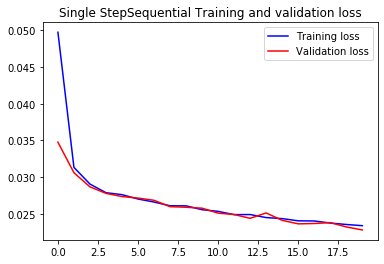

In [53]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [57]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0234,  mae:0.0234,  mse:0.0013,  val_loss:0.0231,  val_mae:0.0231,  val_mse:0.0013,  
....................

In [58]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.46203208


## Adding embedding layer

### Build the model (multiple output)

In [32]:
# Embedding
input_1 = tf.keras.layers.Input(shape=(past_history), name='action')
embedding = tf.keras.layers.Embedding(28, 5, input_length=past_history, name='embedding')(input_1)

#Features
input_2 = tf.keras.layers.Input(shape=(past_history, 6), name='features')

#Concatenation
concat = tf.keras.layers.concatenate([embedding, input_2], name='concat')

# RNN
RNN = tf.keras.layers.LSTM(11,return_sequences=True, name='RNN')(concat)
output= tf.keras.layers.Dense(N_CATEGORIES, activation="softmax", name='output')(RNN)

full_model_sequential= tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

full_model_sequential.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'), metrics=['accuracy'])

print(full_model_sequential.summary())

keras.utils.plot_model(full_model_sequential, 'full_model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
action (InputLayer)             [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 5)         140         action[0][0]                     
__________________________________________________________________________________________________
features (InputLayer)           [(None, 3, 6)]       0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 3, 11)        0           embedding[0][0]                  
                                                                 features[0][0]               

In [33]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = full_model_sequential.fit({'features': x_train_single_sequential[:,:,0:6], 'action': x_train_single_sequential[:,:,6]},y_train_single_sequential, validation_data=({'features': x_val_single_sequential[:,:,0:6], 'action': x_val_single_sequential[:,:,6]}, y_val_single_sequential), epochs=EPOCHS)

NameError: name 'training_size' is not defined

In [34]:
Last_step_prediction = full_model_sequential.predict({'features': x_val_single_sequential[:,:,0:6], 'action': x_val_single_sequential[:,:,6]})[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy()   
_ = m.update_state(y_val_single_sequential[:,N_STEPS-1], Last_step_prediction.argmax(axis=1)) 
m.result().numpy()

0.021390375

# Multi-Step model

## Multi-step model using single step-multioutput model

In [39]:
os.getcwd()

'c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\Simple RNN'

In [40]:
import os, sys
sys.path.append('c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\path_planning')

In [41]:
from simulate_clean import get_next_state
from clean_model import tc
from classes import FlightState

In [44]:
sample_id = 0
initial_action = dataset["out_action"][sample_id]
start = np.append([0, 0, 1, 0, 0, 0],class_to_action(str(initial_action)))
start = np.append(start, [0])
target = np.append(dataset["goal_state"][sample_id],[0,0,0])

model = single_step_sequential_model  

In [45]:
trajectory = np.array(generate_trajectory(model, start, target, initial_action))
teorico = x_train_single_sequential[0]

NameError: name 'generate_trajectory' is not defined

In [46]:
plt.plot(teorico[:,0], teorico[:,1],  label="training")
plt.plot(trajectory[:,0], trajectory[:,1], label="estimated")
plt.plot(0, 0,"rx", label="target")
plt.legend()
plt.show()

NameError: name 'teorico' is not defined

In [47]:
def generate_trajectory(model, start, target, initial_action):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  # Number of points to generate
  num_generate = 4

  # time step used in the action
  time_step = 12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(target[0:6],target[6], target[7])
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(start[0:6],start[6], start[7])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = np.append(norm(distance_long[0:6], data_stats),initial_action)
  input_eval = tf.expand_dims([distance], 0)

  # Empty vector to store the actions
  trajectory_generated = []

  # First point is the initial distance
  trajectory_generated.append(distance)



  # Here batch size == 1 and sequence size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # get the category predicted by the model
      predicted_id = predictions.numpy().argmax(axis=1)

      # Compute the action vector from the category
      action = class_to_action(str(predicted_id[-1]))

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)


      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)

      if boolean:

        # We pass the predicted point as the next input to the model
        # along with the previous hidden state
        FS_current_state = FS_new_state
        current_state= FS_current_state.get_info_formatted()
        distance_long = target - current_state

        distance = np.append(norm(distance_long[0:6], data_stats), predicted_id[-1])
        input_eval = tf.expand_dims([distance], 0)

        trajectory_generated.append(distance)

      else:
        print("End")
        break
          

  return trajectory_generated

In [48]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
future_target = 2
STEP = N_STEPS+1
past_history = STEP - future_target
prediction_type ="multiple_step"

x_train_multi, y_train_multi = multivariate_data(dataset2, dataset2[:, 6], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   prediction_type)
x_val_multi, y_val_multi = multivariate_data(dataset2, dataset2[:, 6],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               prediction_type)

IndexError: index 6 is out of bounds for axis 1 with size 4

We check that the data and label sets have the correct size

In [49]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target Action to predict : {}'.format(y_train_multi[0].shape))

NameError: name 'x_train_multi' is not defined

We prepate the chunks

In [50]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

NameError: name 'x_train_multi' is not defined

We plot a true future

In [51]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 6]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [52]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

NameError: name 'train_data_multi' is not defined

Here is the model with 2 layers. The last layer has the number of predictions as outputs

In [53]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(N_CATEGORIES,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(N_CATEGORIES, activation='softmax'))

multi_step_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'),
              metrics=['accuracy'])

NameError: name 'x_train_multi' is not defined

In [54]:
multi_step_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

This is the prediction shape, which should be (BATCHSIZE, # predicted points)

In [55]:
for x, y in val_data_multi.take(1):
  print (tf.shape(multi_step_model.predict(x)))

NameError: name 'val_data_multi' is not defined

We train the model

In [56]:
EPOCHS = 100

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

NameError: name 'train_data_multi' is not defined

In [57]:
test_loss, test_acc = multi_step_model.evaluate(x_val_multi,  y_val_multi, verbose=2)

print('\nTest accuracy:', test_acc)

NameError: name 'x_val_multi' is not defined

In [58]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

NameError: name 'plot_train_history' is not defined

In [59]:
hist = pd.DataFrame(multi_step_history.history)
hist['epoch'] = multi_step_history.epoch
hist.tail()

NameError: name 'multi_step_history' is not defined

In [60]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [61]:
plotter.plot({'Basic': multi_step_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

NameError: name 'multi_step_history' is not defined

In [62]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])




NameError: name 'train_data_multi' is not defined

In [63]:
test_loss, test_acc = multi_step_model.evaluate(x_val_multi,  y_val_multi, verbose=2)

print('\nTest accuracy:', test_acc)

NameError: name 'x_val_multi' is not defined

In [64]:
plotter.plot({'Early Stopping': early_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

NameError: name 'early_history' is not defined

let's check the predictions

In [65]:
probability_multi_model = tf.keras.Sequential([multi_step_model, 
                                         tf.keras.layers.Softmax()])

ValueError: An empty Model cannot be used as a Layer.

In [66]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], probability_multi_model.predict(x)[0])

NameError: name 'val_data_multi' is not defined